In [1]:
import pickle
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import torch
from collections import defaultdict
import os

In [2]:
def show_weights(filename):
    vals = {}
    actions = 'up right down left'.split()
    with open(filename, 'rb') as file:
        state_dict = torch.load(file, map_location=torch.device("cpu"))
    for key, value in state_dict.items():
        # vals[key+".max"] = value.max().item()
        # vals[key+".min"] = value.min().item()
        for act, row in zip(actions, value.numpy().round(2)):
            vals[f"{key}.{act}"] = row
    return vals

def get_results(filename, rolling_len=200):
    with open(filename, "rb") as file:
        results = pickle.load(file)
    if len(results[0]) < 500:
        new_results = []
        for row in results:
            new_results.append([])
            for item in row:
                new_results[-1].extend([item]*1000)

        # truncate to nearest multiple of 10k
        n = len(new_results[0])
        n = (n // 10000) * 10000
        results = [row[:n] for row in new_results]
    dirname = os.path.dirname(filename)
    rolled_up = []
    frame = []
    for seed, result in enumerate(results):
        r = pd.Series(result).rolling(rolling_len, min_periods=1).mean().dropna()
        r = list(r)
        rolled_up.append(r)
        weights_file = os.path.join(dirname, f"weights.{seed}.pth")
        vals = show_weights(weights_file)
        vals["perf"] = r[-1]
        frame.append(vals)
    frame = pd.DataFrame.from_records(frame)
    # display(frame.sort_values("perf", ascending=False))
    rolled_up = np.array(rolled_up)

    avg_rewards = np.median(rolled_up, 0)
    min_rewards = rolled_up.min(0)
    max_rewards = rolled_up.max(0)
    std_rewards = rolled_up.std(0)

    bot = np.maximum(avg_rewards - std_rewards, min_rewards)
    top = np.minimum(avg_rewards + std_rewards, max_rewards)
    return avg_rewards, bot, top


In [3]:
vals = defaultdict(int)
for seed in range(10):
    # print(seed)
    with open(f"saves/reinforce/tiny/weights.{seed}.pth", 'rb') as file:
        state_dict = torch.load(file, map_location=torch.device("cpu"))
    for key, value in state_dict.items():
        # print("\t", key, value.max(), value.min())
        vals[key+".max"] = max(vals[key+".max"], value.max().item())
        vals[key+".min"] = min(vals[key+".min"], value.min().item())

print("Reinforce")
for key, value in vals.items():
    print(key, value)


Reinforce
fc.weight.max 0.5456724762916565
fc.weight.min -0.8427281379699707
fc.bias.max 0.8449665904045105
fc.bias.min -0.7622199058532715


In [4]:
vals = defaultdict(int)
for seed in range(10):
    # print(seed)
    with open(f"saves/sf_reinforce/tiny/weights.{seed}.pth", 'rb') as file:
        state_dict = torch.load(file, map_location=torch.device("cpu"))
    for key, value in state_dict.items():
        vals[key+".max"] = max(vals[key+".max"], value.max().item())
        vals[key+".min"] = min(vals[key+".min"], value.min().item())

print("SPSA")
for key, value in vals.items():
    print(key, value)


SPSA
fc.weight.max 0.5448506474494934
fc.weight.min -0.5521352291107178
fc.bias.max 0.44599175453186035
fc.bias.min -0.47158095240592957


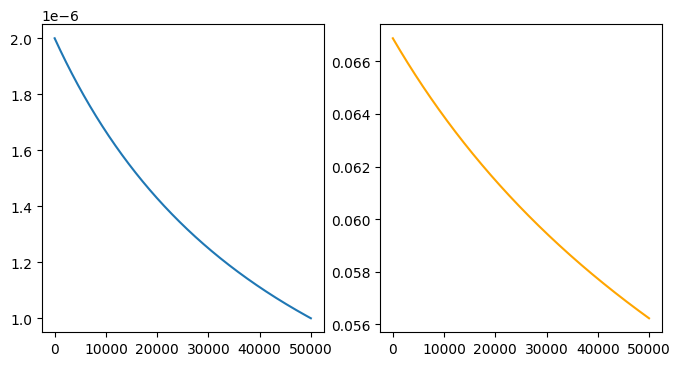

In [5]:
def get_delta(episode):
    return (2e-5 / (1 + episode * 2e-5)) ** 0.25


def get_alpha(episode):
    return 2e-6 / (1 + episode * 2e-5)


episode = np.arange(50000)
alpha = get_alpha(episode)
delta = get_delta(episode)

fig, ax = plt.subplots(1, 2, figsize=(8, 4))
ax[0].plot(episode, alpha)
ax[1].plot(episode, delta, color="orange")


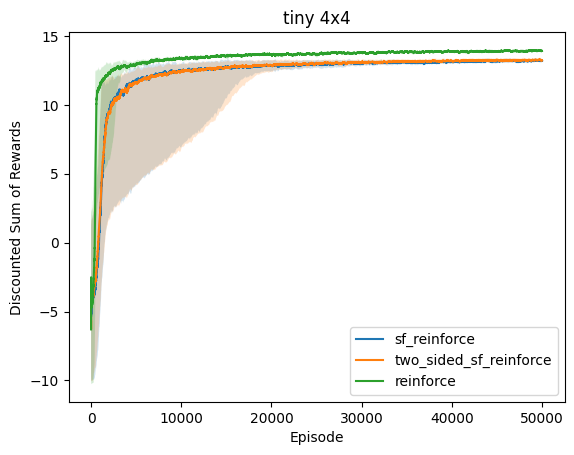

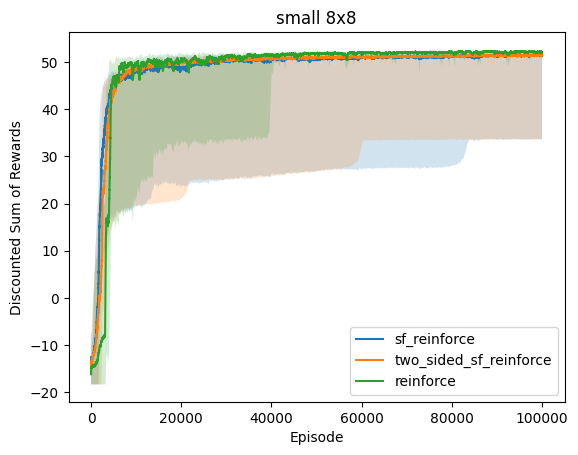

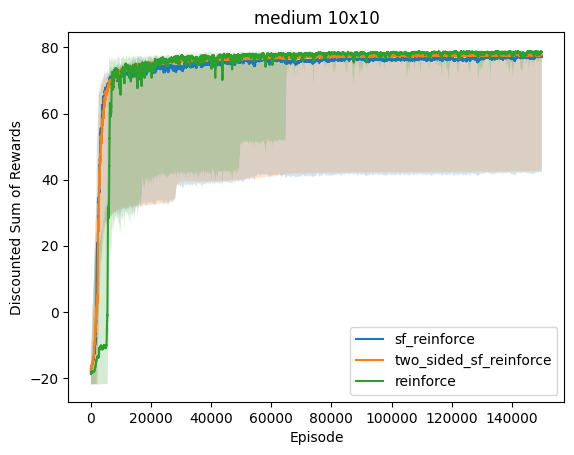

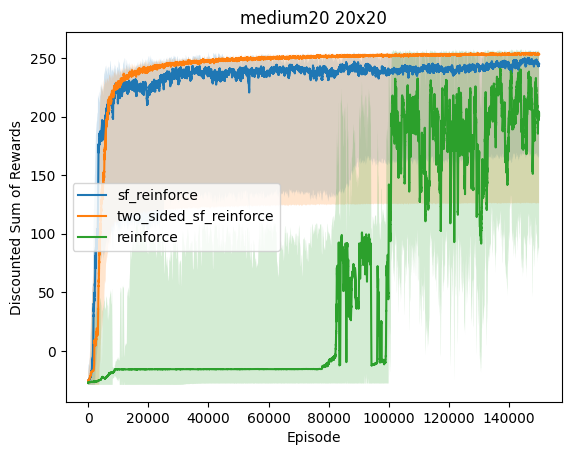

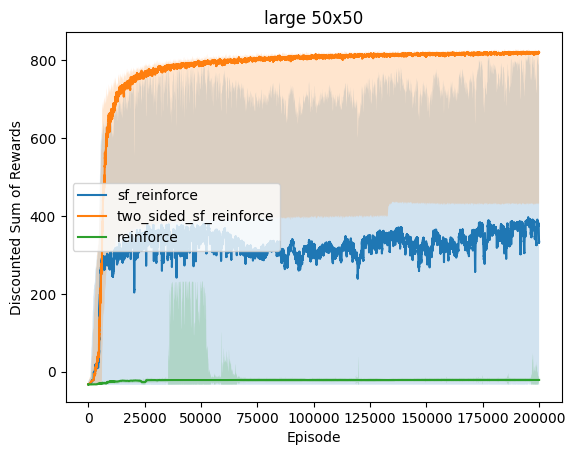

In [6]:
gridsizes = ["4x4", "8x8", "10x10", "20x20", "50x50"]
for grid, gridsize in zip("tiny small medium medium20 large".split(), gridsizes):
    for algo in "sf_reinforce two_sided_sf_reinforce reinforce".split():
        dirname = os.path.join("saves", algo, grid)
        filename = list(filter(lambda x: x.endswith(".pkl"), os.listdir(dirname)))[0]
        path = os.path.join(dirname, filename)
        avg_rewards, bot, top = get_results(path)
        plt.plot(avg_rewards, label=algo)
        plt.fill_between(range(len(avg_rewards)), bot, top, alpha=0.2)
    plt.title(f"{grid} {gridsize}")
    plt.xlabel('Episode')
    plt.ylabel('Discounted Sum of Rewards')
    plt.legend()
    plt.show()


sf_reinforce_0.101 medium
two_sided_sf_reinforce_0.101 medium


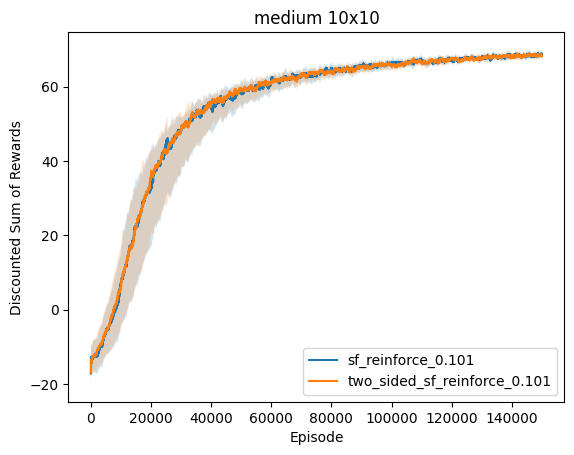

sf_reinforce_0.15 medium
two_sided_sf_reinforce_0.15 medium


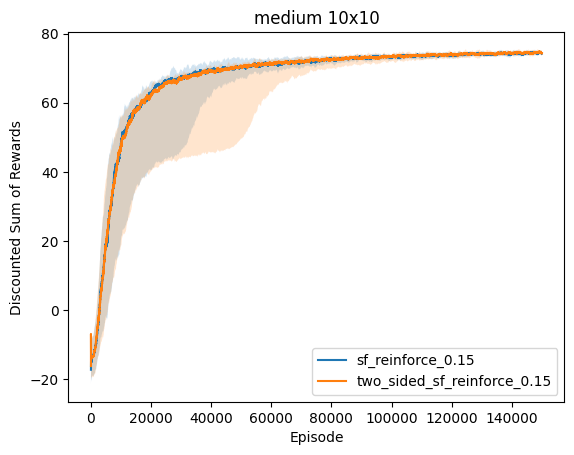

sf_reinforce_0.25 medium
two_sided_sf_reinforce_0.25 medium


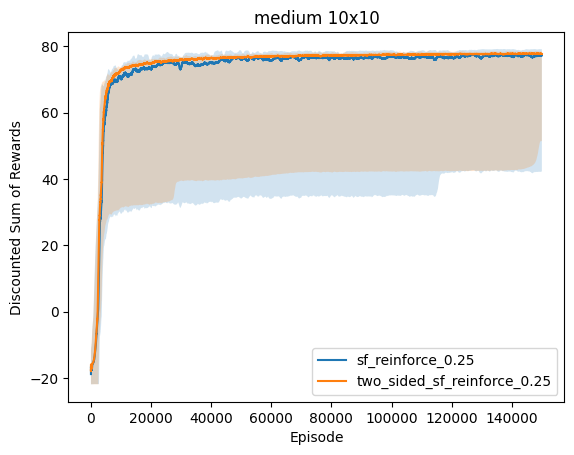

sf_reinforce_0.35 medium
two_sided_sf_reinforce_0.35 medium


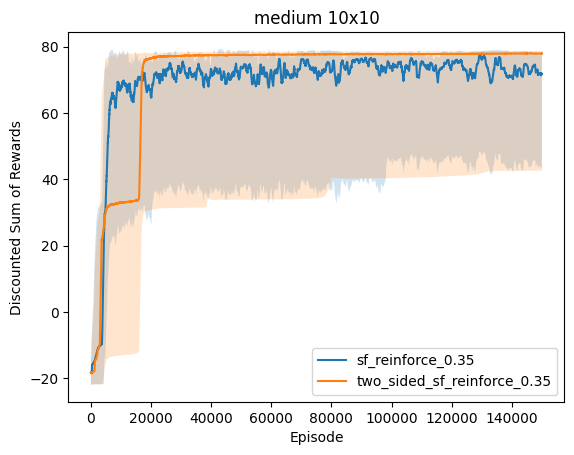

sf_reinforce_0.45 medium
two_sided_sf_reinforce_0.45 medium


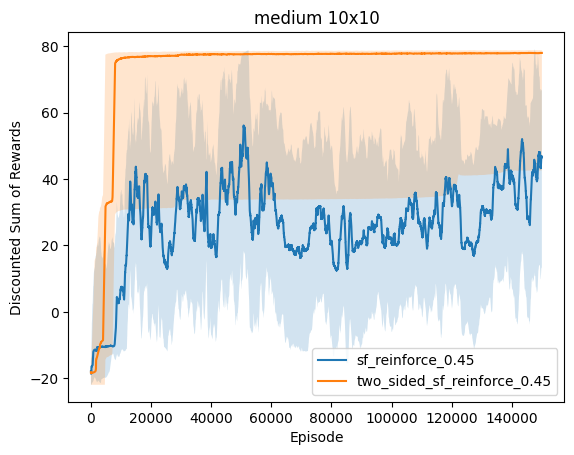

sf_reinforce_const_0.175 medium
two_sided_sf_reinforce_const_0.175 medium


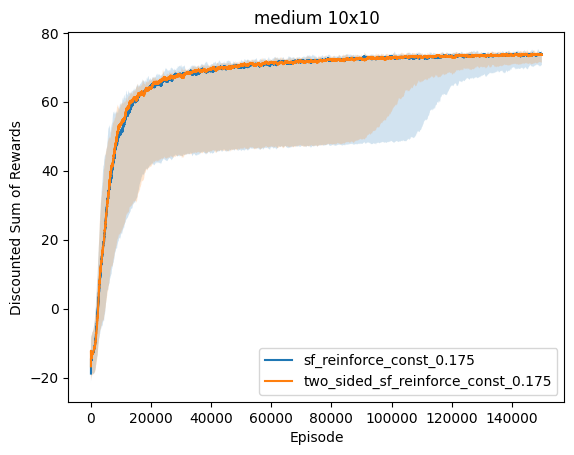

sf_reinforce_const_0.5 medium
two_sided_sf_reinforce_const_0.5 medium


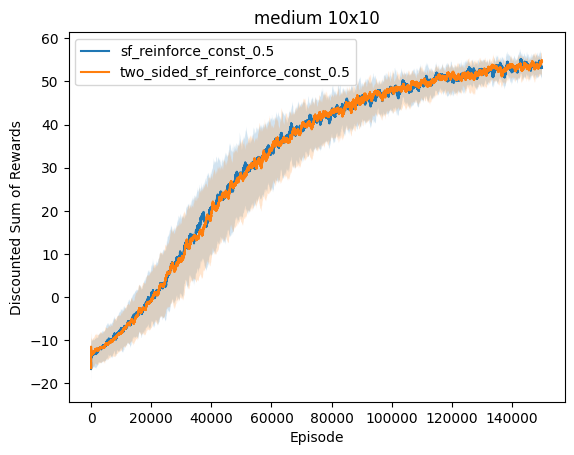

In [7]:
gridsizes = ["4x4", "8x8", "10x10", "20x20", "50x50"]
for grid, gridsize in zip(["medium"], ["10x10"]):
    for suffix in "0.101 0.15 0.25 0.35 0.45 const_0.175 const_0.5".split():
        for algo in "sf_reinforce two_sided_sf_reinforce".split():
            name = algo + "_" + suffix
            dirname = os.path.join("saves", name, grid)
            filename = list(filter(lambda x: x.endswith(".pkl"), os.listdir(dirname)))[0]
            path = os.path.join(dirname, filename)
            print(name, grid)
            avg_rewards, bot, top = get_results(path, 800)
            plt.plot(avg_rewards, label=name)
            plt.fill_between(range(len(avg_rewards)), bot, top, alpha=0.2)
        # plt.plot([80] * len(avg_rewards), label="bound")
        plt.title(f"{grid} {gridsize}")
        plt.xlabel('Episode')
        plt.ylabel('Discounted Sum of Rewards')
        plt.legend()
        plt.show()


0.15 0.17402271240926254
0.25 0.054344194757983286
0.35 0.016996511436359246
0.45000000000000007 0.005323956688094775


Text(0.5, 1.0, 'Different exp-decay schemes for delta')

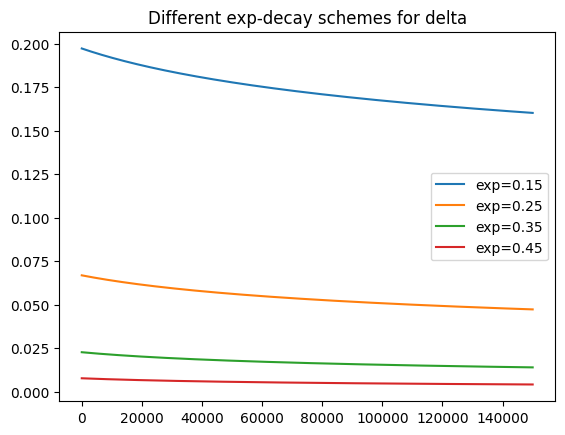

In [8]:
from spsa import get_delta

for delta_pow in np.arange(0.15, 0.5, 0.1):
    ep = np.arange(150000)
    delta = get_delta(ep, delta_pow, None)
    print(delta_pow, delta.mean())
    plt.plot(ep, delta, label="exp="+str(round(delta_pow, 2)))

# for const_delta in [0.175, 0.5]:
#     ep = np.arange(150000)
#     delta = np.ones_like(ep) * const_delta
#     plt.plot(ep, delta, label="const_delta="+str(round(const_delta, 3)))

plt.legend();
plt.title("Different exp-decay schemes for delta")


In [9]:
# table for experiment 1 different sizes, different algorithm
frame = []
gridsizes = ["4x4", "8x8", "10x10", "20x20", "50x50"]
for algo in "reinforce sf_reinforce two_sided_sf_reinforce".split():
    for grid, gridsize in zip("tiny small medium medium20 large".split(), gridsizes):
        dirname = os.path.join("saves", algo, grid)
        filename = list(filter(lambda x: x.endswith(".pkl"), os.listdir(dirname)))[0]
        path = os.path.join(dirname, filename)
        with open(path, "rb") as file:
            results = np.array(pickle.load(file))

        per_seed_results = results[:, -200:].mean(1)
        disp = f"{per_seed_results.mean():.2f} +- {per_seed_results.std():.1f}"
        frame.append((algo, gridsize, disp))
frame = pd.DataFrame(frame).pivot(index=0, columns=1).reset_index()
frame.columns = ["Algorithm / Gridsize"] + [col for _, col in frame.columns][1:]
display(frame)
print(
    frame[["Algorithm / Gridsize"] + gridsizes]
    .to_latex(index=False, escape=True)
    .replace("toprule", "hline")
    .replace("bottomrule", "hline")
    .replace("midrule", "hline")
    .replace("+-", "$\\pm$")
)


,Algorithm / Gridsize,10x10,20x20,4x4,50x50,8x8
0,reinforce,76.90 +- 4.9,144.89 +- 113.8,13.90 +- 0.1,-18.79 +- 8.4,50.74 +- 2.3
1,sf_reinforce,59.80 +- 35.0,220.24 +- 78.8,13.23 +- 0.1,376.29 +- 401.4,45.40 +- 17.7
2,two_sided_sf_reinforce,60.39 +- 35.0,170.68 +- 127.4,13.26 +- 0.1,562.89 +- 387.7,45.52 +- 17.8


\begin{tabular}{llllll}
\hline
Algorithm / Gridsize & 4x4 & 8x8 & 10x10 & 20x20 & 50x50 \\
\hline
reinforce & 13.90 $\pm$ 0.1 & 50.74 $\pm$ 2.3 & 76.90 $\pm$ 4.9 & 144.89 $\pm$ 113.8 & -18.79 $\pm$ 8.4 \\
sf\_reinforce & 13.23 $\pm$ 0.1 & 45.40 $\pm$ 17.7 & 59.80 $\pm$ 35.0 & 220.24 $\pm$ 78.8 & 376.29 $\pm$ 401.4 \\
two\_sided\_sf\_reinforce & 13.26 $\pm$ 0.1 & 45.52 $\pm$ 17.8 & 60.39 $\pm$ 35.0 & 170.68 $\pm$ 127.4 & 562.89 $\pm$ 387.7 \\
\hline
\end{tabular}



In [10]:
# table for experiment 2 different decays
frame = []
grid, gridsize = "medium", "10x10"
for algo in "sf_reinforce two_sided_sf_reinforce".split():
    for decay in [0.101, 0.15, 0.25, 0.35, 0.45]:
        dirname = os.path.join("saves", f"{algo}_{decay}", grid)
        filename = list(filter(lambda x: x.endswith(".pkl"), os.listdir(dirname)))[0]
        path = os.path.join(dirname, filename)
        with open(path, "rb") as file:
            results = np.array(pickle.load(file))

        per_seed_results = results[:, -200:].mean(1)
        disp = f"{per_seed_results.mean():.2f} +- {per_seed_results.std():.1f}"
        frame.append((algo, decay, disp))
frame = pd.DataFrame(frame).pivot(index=0, columns=1).reset_index()
frame.columns = ["Algorithm / Decay"] + [col for _, col in frame.columns][1:]
display(frame)
print(
    frame
    .to_latex(index=False, escape=True)
    .replace("toprule", "hline")
    .replace("bottomrule", "hline")
    .replace("midrule", "hline")
    .replace("+-", "$\\pm$")
)


,Algorithm / Decay,0.101,0.15,0.25,0.35,0.45
0,sf_reinforce,68.72 +- 1.5,74.07 +- 0.7,59.45 +- 35.0,62.60 +- 28.4,31.33 +- 34.0
1,two_sided_sf_reinforce,68.10 +- 1.3,74.18 +- 0.6,68.49 +- 26.3,60.40 +- 35.4,60.46 +- 35.4


\begin{tabular}{llllll}
\hline
Algorithm / Decay & 0.101000 & 0.150000 & 0.250000 & 0.350000 & 0.450000 \\
\hline
sf\_reinforce & 68.72 $\pm$ 1.5 & 74.07 $\pm$ 0.7 & 59.45 $\pm$ 35.0 & 62.60 $\pm$ 28.4 & 31.33 $\pm$ 34.0 \\
two\_sided\_sf\_reinforce & 68.10 $\pm$ 1.3 & 74.18 $\pm$ 0.6 & 68.49 $\pm$ 26.3 & 60.40 $\pm$ 35.4 & 60.46 $\pm$ 35.4 \\
\hline
\end{tabular}



In [11]:
# table for experiment 2 different decays
frame = []
grid, gridsize = "medium", "10x10"
for algo in "sf_reinforce two_sided_sf_reinforce".split():
    for const in [0.175, 0.5]:
        dirname = os.path.join("saves", f"{algo}_const_{const}", grid)
        filename = list(filter(lambda x: x.endswith(".pkl"), os.listdir(dirname)))[0]
        path = os.path.join(dirname, filename)
        with open(path, "rb") as file:
            results = np.array(pickle.load(file))

        per_seed_results = results[:, -200:].mean(1)
        disp = f"{per_seed_results.mean():.2f} +- {per_seed_results.std():.1f}"
        frame.append((algo, const, disp))
frame = pd.DataFrame(frame).pivot(index=0, columns=1).reset_index()
frame.columns = ["Algorithm / Decay"] + [col for _, col in frame.columns][1:]
display(frame)
print(
    frame
    .to_latex(index=False, escape=True)
    .replace("toprule", "hline")
    .replace("bottomrule", "hline")
    .replace("midrule", "hline")
    .replace("+-", "$\\pm$")
)


,Algorithm / Decay,0.175,0.5
0,sf_reinforce,72.66 +- 3.6,52.60 +- 2.8
1,two_sided_sf_reinforce,73.29 +- 1.9,53.10 +- 3.2


\begin{tabular}{lll}
\hline
Algorithm / Decay & 0.175000 & 0.500000 \\
\hline
sf\_reinforce & 72.66 $\pm$ 3.6 & 52.60 $\pm$ 2.8 \\
two\_sided\_sf\_reinforce & 73.29 $\pm$ 1.9 & 53.10 $\pm$ 3.2 \\
\hline
\end{tabular}



In [12]:
frame = []
grid, gridsize = "large", "50x50"
for algo in "sf_reinforce two_sided_sf_reinforce".split():
    for const in [0.175, 0.5, 0.7]:
        dirname = os.path.join("saves", f"{algo}_const_{const}", grid)
        filename = list(filter(lambda x: x.endswith(".pkl"), os.listdir(dirname)))[0]
        path = os.path.join(dirname, filename)
        with open(path, "rb") as file:
            results = np.array(pickle.load(file))

        per_seed_results = results[:, -200:].mean(1)
        disp = f"{per_seed_results.mean():.2f} +- {per_seed_results.std():.1f}"
        frame.append((algo, const, disp))
frame = pd.DataFrame(frame).pivot(index=0, columns=1).reset_index()
frame.columns = ["Algorithm / Decay"] + [col for _, col in frame.columns][1:]
display(frame)
print(
    frame
    .to_latex(index=False, escape=True)
    .replace("toprule", "hline")
    .replace("bottomrule", "hline")
    .replace("midrule", "hline")
    .replace("+-", "$\\pm$")
)


,Algorithm / Decay,0.175,0.5,0.7
0,sf_reinforce,677.55 +- 233.1,446.65 +- 26.8,254.74 +- 35.6
1,two_sided_sf_reinforce,665.50 +- 229.1,437.26 +- 21.7,247.09 +- 33.0


\begin{tabular}{llll}
\hline
Algorithm / Decay & 0.175000 & 0.500000 & 0.700000 \\
\hline
sf\_reinforce & 677.55 $\pm$ 233.1 & 446.65 $\pm$ 26.8 & 254.74 $\pm$ 35.6 \\
two\_sided\_sf\_reinforce & 665.50 $\pm$ 229.1 & 437.26 $\pm$ 21.7 & 247.09 $\pm$ 33.0 \\
\hline
\end{tabular}



sf_reinforce_const_0.175 large
two_sided_sf_reinforce_const_0.175 large


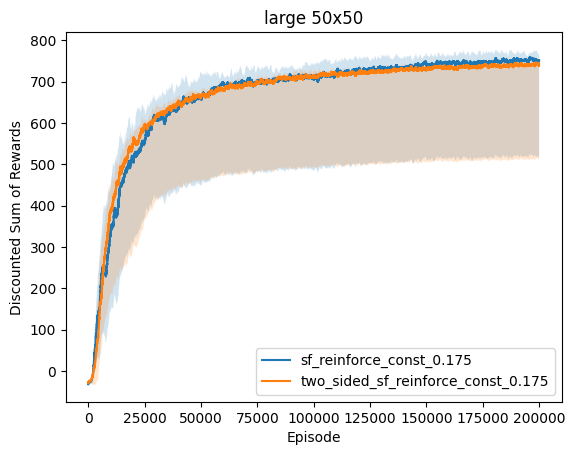

sf_reinforce_const_0.5 large
two_sided_sf_reinforce_const_0.5 large


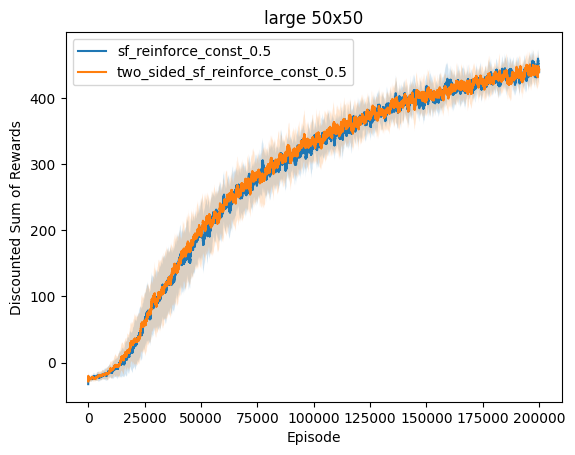

sf_reinforce_const_0.7 large
two_sided_sf_reinforce_const_0.7 large


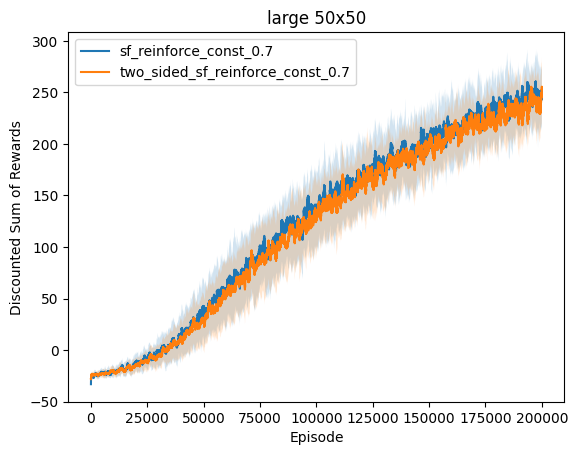

In [13]:
gridsizes = ["4x4", "8x8", "10x10", "20x20", "50x50"]
for grid, gridsize in zip(["large"], ["50x50"]):
    for suffix in "const_0.175 const_0.5 const_0.7".split():
        for algo in "sf_reinforce two_sided_sf_reinforce".split():
            name = algo + "_" + suffix
            dirname = os.path.join("saves", name, grid)
            filename = list(filter(lambda x: x.endswith(".pkl"), os.listdir(dirname)))[0]
            path = os.path.join(dirname, filename)
            print(name, grid)
            avg_rewards, bot, top = get_results(path, 800)
            plt.plot(avg_rewards, label=name)
            plt.fill_between(range(len(avg_rewards)), bot, top, alpha=0.2)
        plt.title(f"{grid} {gridsize}")
        plt.xlabel('Episode')
        plt.ylabel('Discounted Sum of Rewards')
        plt.legend()
        plt.show()


In [14]:
keys = [
    algo + "_" + suffix
        for algo in "sf_reinforce_signed two_sided_sf_reinforce_signed".split()
    for suffix in "const_0.175 const_0.175_small_alpha".split()
]

keys

['sf_reinforce_signed_const_0.175',
 'sf_reinforce_signed_const_0.175_small_alpha',
 'two_sided_sf_reinforce_signed_const_0.175',
 'two_sided_sf_reinforce_signed_const_0.175_small_alpha']

sf_reinforce_signed_const_0.175_start_alpha=0.02 large
two_sided_sf_reinforce_signed_const_0.175_start_alpha=0.02 large


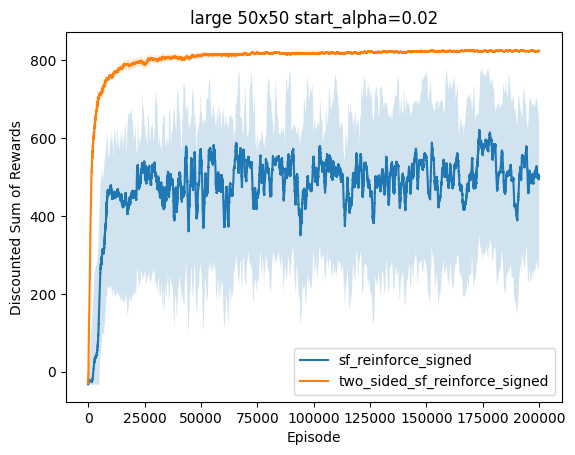

sf_reinforce_signed_const_0.175_start_alpha=0.0002 large
two_sided_sf_reinforce_signed_const_0.175_start_alpha=0.0002 large


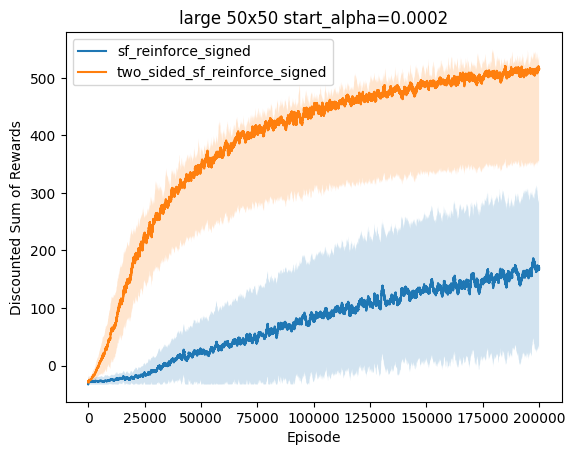

sf_reinforce_signed_const_0.175_start_alpha=2e-06 large
two_sided_sf_reinforce_signed_const_0.175_start_alpha=2e-06 large


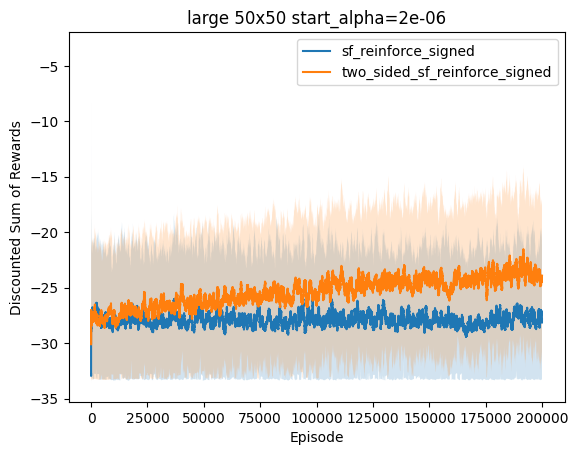

In [15]:
# mapping = dict(zip(['sf_reinforce_signed_const_0.175',
#  'sf_reinforce_signed_const_0.175_small_alpha',
#  'two_sided_sf_reinforce_signed_const_0.175',
#  'two_sided_sf_reinforce_signed_const_0.175_small_alpha'], ["sf_reinforce_signed_alpha_2e-4"]))
frame = []
for grid, gridsize in zip(["large"], ["50x50"]):
    for suffix in "const_0.175_start_alpha=0.02 const_0.175_start_alpha=0.0002 const_0.175_start_alpha=2e-06".split():
        for algo in "sf_reinforce_signed two_sided_sf_reinforce_signed".split():
            name = algo + "_" + suffix
            dirname = os.path.join("saves", name, grid)
            filename = list(filter(lambda x: x.endswith(".pkl"), os.listdir(dirname)))[0]
            path = os.path.join(dirname, filename)
            print(name, grid)
            avg_rewards, bot, top = get_results(path, 800)
            plt.plot(avg_rewards, label=algo)
            plt.fill_between(range(len(avg_rewards)), bot, top, alpha=0.2)

            with open(path, "rb") as file:
                results = np.array(pickle.load(file))

            per_seed_results = results[:, -200:].mean(1)
            disp = f"{per_seed_results.mean():.2f} +- {per_seed_results.std():.1f}"
            frame.append((algo, suffix.split("_")[-2], disp))
        plt.title(f"{grid} {gridsize} start_alpha={suffix.split('=')[-1]}")
        plt.xlabel('Episode')
        plt.ylabel('Discounted Sum of Rewards')
        plt.legend()
        plt.show()


In [20]:
# frame = []
# for grid, gridsize in zip(["large"], ["50x50"]):
#     for suffix in "const_delta=0.175_start_alpha=0.02_grad_bound=1.5 const_delta=0.5_start_alpha=0.02_grad_bound=1.5".split():
#         for algo in "sf_reinforce two_sided_sf_reinforce".split():
#             name = algo + "_" + suffix
#             dirname = os.path.join("saves", name, grid)
#             filename = list(filter(lambda x: x.endswith(".pkl"), os.listdir(dirname)))[0]
#             path = os.path.join(dirname, filename)
#             print(name, grid)
#             avg_rewards, bot, top = get_results(path, 800)
#             plt.plot(avg_rewards, label=name)
#             plt.fill_between(range(len(avg_rewards)), bot, top, alpha=0.2)

#             with open(path, "rb") as file:
#                 results = np.array(pickle.load(file))

#             per_seed_results = results[:, -200:].mean(1)
#             disp = f"{per_seed_results.mean():.2f} +- {per_seed_results.std():.1f}"
#             frame.append((name, suffix.split("_")[-2], disp))
#         plt.title(f"Gradient Clipping on 50x50 grid")
#         plt.xlabel('Episode')
#         plt.ylabel('Discounted Sum of Rewards')
#         plt.legend()
#         plt.show()

# frame = pd.DataFrame(frame).pivot(index=0, columns=1).reset_index()
# frame.columns = ["Algorithm / Decay"] + [col for _, col in frame.columns][1:]
# # frame = frame_sgn.merge(frame, on="Algorithm / Decay")
# display(frame)
# print(
#     frame
#     .to_latex(index=False, escape=True)
#     .replace("toprule", "hline")
#     .replace("bottomrule", "hline")
#     .replace("midrule", "hline")
#     .replace("+-", "$\\pm$")
# )

## Large experiments

### Experiment names

In [21]:
def get_exp_name(conf):
    if 'grad_bound' in conf:
        return 'grad_clip'
    if 'signed' in conf:
        return 'signed'
    if 'const' in conf:
        return 'const_delta'
    return 'vanilla'

large_exp = []
exp: str
for exp in os.listdir("saves"):
    if 'large' in os.listdir(f"saves/{exp}") and exp != 'ppo':
        dirname = os.path.join('saves', exp, 'large')
        filename = list(filter(lambda x: x.endswith(".pkl"), os.listdir(dirname)))[0]
        path = os.path.join(dirname, filename)
        with open(path, "rb") as file:
            results = np.array(pickle.load(file))

        algo = (
            'sf_reinforce' if exp.startswith('sf_reinforce')
            else 'two_sided_sf_reinforce' if exp.startswith('two_sided_sf_reinforce')
            else 'reinforce'
        )
        per_seed_results = results[:, -200:].mean(1)
        mean, std = pd.Series(per_seed_results).mean().round(2), per_seed_results.std().round(1)
        disp = f"{mean} +- {std}"
        large_exp.append([algo, mean, std, exp, disp])
df = pd.DataFrame(large_exp, columns=["algo", 'mean', 'std', 'conf', 'disp'])
# df = df[df['mean'] > -20]

df['exp'] = df.conf.apply(get_exp_name)
df = df.sort_values(["algo", "exp", 'mean', 'std'], ignore_index=True)
df = df.groupby(["exp", "algo"]).last().reset_index()
df


,exp,algo,mean,std,conf,disp
0,const_delta,sf_reinforce,677.55,233.1,sf_reinforce_const_0.175,677.55 +- 233.1
1,const_delta,two_sided_sf_reinforce,665.50,229.1,two_sided_sf_reinforce_const_0.175,665.5 +- 229.1
2,grad_clip,sf_reinforce,483.68,215.3,sf_reinforce_const_delta=0.5_start_alpha=0.02_...,483.68 +- 215.3
3,grad_clip,two_sided_sf_reinforce,824.96,5.6,two_sided_sf_reinforce_const_delta=0.175_start...,824.96 +- 5.6
4,signed,sf_reinforce,424.93,254.5,sf_reinforce_signed_const_0.175_start_alpha=0.02,424.93 +- 254.5
5,signed,two_sided_sf_reinforce,823.68,3.1,two_sided_sf_reinforce_signed_const_0.175_star...,823.68 +- 3.1
6,vanilla,reinforce,-18.79,8.4,reinforce,-18.79 +- 8.4
7,vanilla,sf_reinforce,376.29,401.4,sf_reinforce,376.29 +- 401.4
8,vanilla,two_sided_sf_reinforce,562.89,387.7,two_sided_sf_reinforce,562.89 +- 387.7


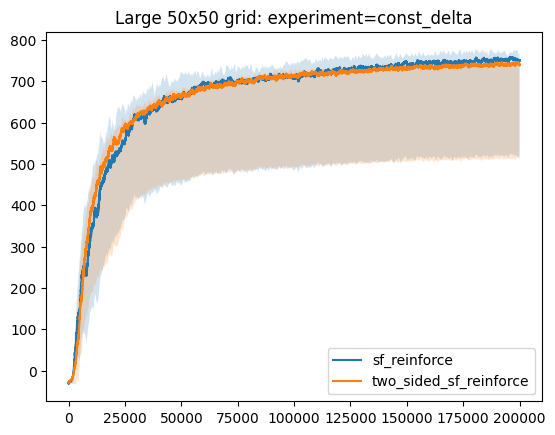

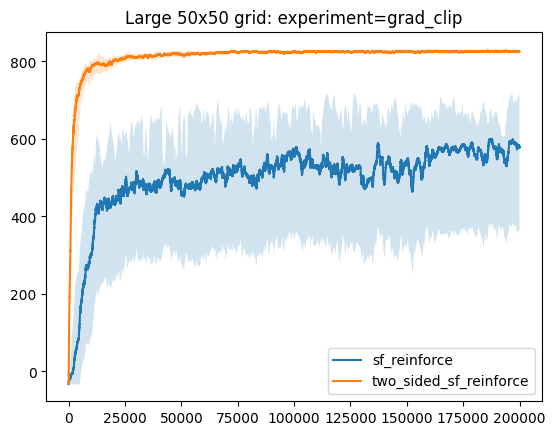

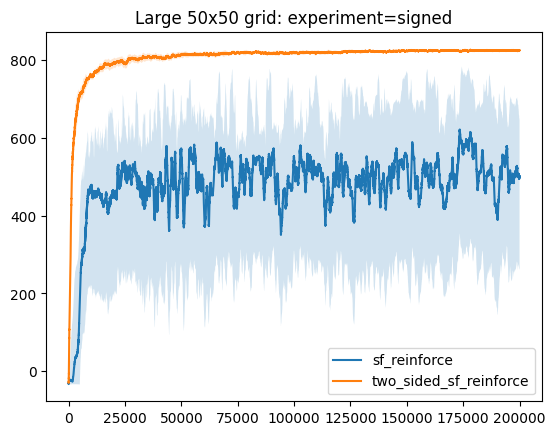

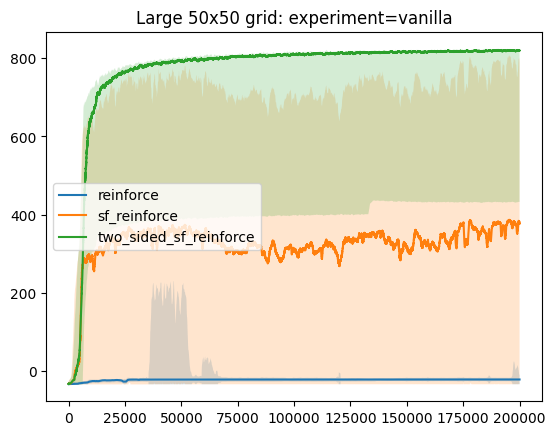

In [19]:
for exp, item in df.groupby("exp"):
    for row in item.itertuples():
        dirname = os.path.join("saves", row.conf, "large")
        filename = list(filter(lambda x: x.endswith(".pkl"), os.listdir(dirname)))[0]
        path = os.path.join(dirname, filename)
        avg_rewards, bot, top = get_results(path, 800)
        plt.plot(avg_rewards, label=row.algo)
        plt.fill_between(range(len(avg_rewards)), bot, top, alpha=0.2)
    plt.title(f"Large 50x50 grid: experiment={exp}")
    plt.legend()
    plt.show()

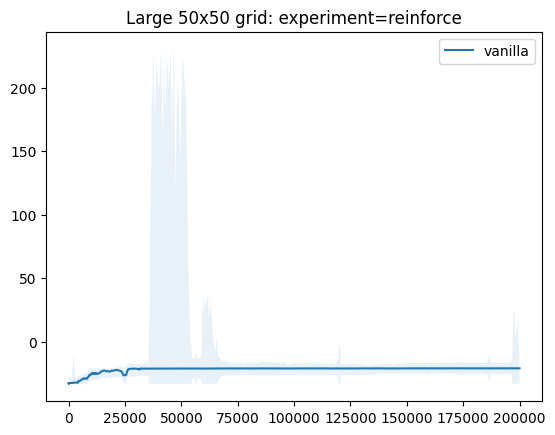

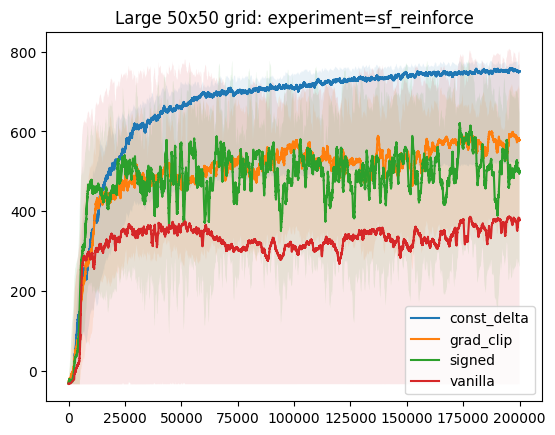

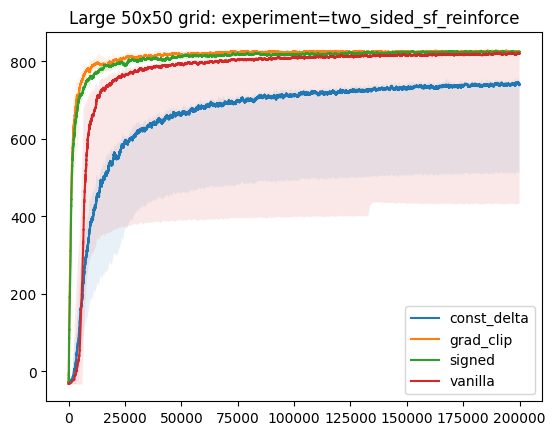

In [24]:
for algo, item in df.groupby("algo"):
    for row in item.itertuples():
        dirname = os.path.join("saves", row.conf, "large")
        filename = list(filter(lambda x: x.endswith(".pkl"), os.listdir(dirname)))[0]
        path = os.path.join(dirname, filename)
        avg_rewards, bot, top = get_results(path, 800)
        plt.plot(avg_rewards, label=row.exp)
        plt.fill_between(range(len(avg_rewards)), bot, top, alpha=0.1)
    plt.title(f"Large 50x50 grid: experiment={algo}")
    plt.legend()
    plt.show()